In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 
bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')

### Data Retrieval

In [3]:
REFRESH=False

In [4]:
if REFRESH:
    
    sql = '''
        DECLARE latest_date DATE;
        SET latest_date = (
            SELECT MAX(offer_end_date) 
            FROM `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales` fcs
            WHERE campaign_code IN (
                SELECT DISTINCT campaign_code
                FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_AUDIENCE_MASTER`
            )
        );
        
        CREATE OR REPLACE TABLE `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_FORECASTING_MONTH_DEV` AS

        WITH dates_campaign AS (
            SELECT * 
            FROM (
                SELECT DISTINCT fp_start_date, fw_start_date
                FROM `wx-bq-poc.loyalty.dim_date`
                WHERE fp_start_date >= '2020-08-31'
                    AND DATE(fp_end_date) < current_date('Australia/ACT')
            )
                CROSS JOIN (
                    SELECT DISTINCT 
                        campaign_code, 
                        CASE WHEN campaign_type = 'MP' AND campaign_length = 7 THEN 'MP1'
                                WHEN campaign_type = 'MP' AND campaign_length = 21 THEN 'MP3'
                                WHEN campaign_type = 'SS' AND campaign_length = 7 THEN 'SS1'
                                WHEN campaign_type = 'SS' AND campaign_length = 14 THEN 'SS2'
                                ELSE campaign_type 
                        END AS offer_type,
                    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_AUDIENCE_MASTER`
                )
            GROUP BY 1, 2, 3, 4
        ),

        master_audience AS (
            SELECT
                campaign_start_date,
                campaign_code,
                COUNT(DISTINCT crn) AS audience
            FROM
                `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales`
            WHERE campaign_code IN (
                SELECT DISTINCT campaign_code 
                FROM`gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_AUDIENCE_MASTER`
            )
            GROUP BY 1, 2
        ),

        promo AS (
            SELECT 
                fcs.campaign_start_date,
                fcs.offer_start_date,
                a.campaign_code,
                a.audience,
                0 AS post_week_flag,
                COUNT(DISTINCT fcs.redeem_flag) AS redeemers,
                SUM(fcs.attributed_inc_sales) AS inc_sales,
                SUM(fcs.reward_val) AS reward_val
            FROM
                `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales` fcs
                JOIN master_audience a 
                    ON fcs.campaign_start_date = DATE(a.campaign_start_date)
                    AND fcs.campaign_code = a.campaign_code
            GROUP BY 1, 2, 3, 4
        ), 

        post AS (
            SELECT  
                ca.campaign_start_date,
                ca.fw_start_date,
                ca.campaign_code,
                a.audience,
                1 AS post_week_flag,
                0 AS redeemers,
                SUM(ca.inc_sales) AS inc_sales,
                0 AS reward_val
            FROM 
                `wx-bq-poc.loyalty_bi_analytics.cp_att_crn_halo_post_all` ca
                JOIN master_audience a 
                    ON ca.campaign_start_date = DATE(a.campaign_start_date)
                    AND ca.campaign_code = a.campaign_code
            GROUP BY 1, 2, 3, 4
        ),

        promo_post AS (
            SELECT * FROM promo 
            UNION ALL
            SELECT * FROM post
        )

        SELECT
            dc.offer_type,
            dc.fp_start_date,
            SUM(audience) AS promo_post_audience,
            SUM(audience) - SUM(CASE WHEN post_week_flag = 1 THEN audience ELSE 0 END) AS promo_audience,
            SUM(redeemers) AS redeemers,
            SUM(inc_sales) AS inc_sales,
            SUM(reward_val) AS reward_val
        FROM 
            dates_campaign dc
            LEFT JOIN promo_post pp
                ON dc.fw_start_date = pp.offer_start_date
                AND dc.campaign_code = pp.campaign_code
        GROUP BY 1, 2
        ORDER BY 1, 2;
    '''

    response = bq.query(sql).result()

In [5]:
sql = '''
    SELECT *
    FROM `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_FORECASTING_MONTH_DEV`
'''

data = bq.query(sql).result().to_dataframe()

data['inc_sales'] = data['inc_sales'].astype(float)
data['redeemers'] = data['redeemers'].astype(float)
data['reward_val'] = data['reward_val'].astype(float)
data['promo_post_audience'] = data['promo_post_audience'].astype(float)
data['promo_audience'] = data['promo_audience'].astype(float)

data['rpc'] = data['inc_sales'] / data['promo_post_audience']
data['rdm'] = data['redeemers'] / data['promo_audience']
data['cpc'] = data['reward_val'] / data['promo_audience']

data['audience'] = data['promo_audience']

### Input Parameters

In [6]:
OFFER_TYPE = '2C'
METRIC = 'rdm'

if METRIC in ['rdm', 'cpc']:
    SCALE = 'promo_audience'
else:
    SCALE = 'promo_post_audience'
    
WINDOW = 2

In [7]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [8]:
def fortnight_impute(df):
    
    def _fortnight_impute(row):
        if np.isnan(row['y']) and ~np.isnan(row['z']):
            return 0
        else:
            return row['y']
        
    if OFFER_TYPE not in ['SS2', 'SGU']:
    
        df['z'] = df['y'].shift(1)
        df['y'] = df.apply(_fortnight_impute, axis=1)
    
    return df[['ds', 'scale', 'y']]


def prophet_impute(df):        
    
    def _prophet_impute(row):
        if np.isnan(row['y']):
            return row['yhat']
        else:
            return row['y']
    
    # use prophet to interpolate
    m = Prophet()
#     m.add_seasonality(name='2-week', period=14, fourier_order=2)
    
    with suppress_stdout_stderr():
        m.fit(df)

    future = m.make_future_dataframe(periods=0, freq='w')
    forecast = m.predict(future)
    
    if OFFER_TYPE == 'TMP':
        forecast['yhat'] = forecast['2-week']
    
    forecast = forecast[['ds', 'yhat']]
    forecast['ds'] = forecast['ds'].apply(lambda x: x.date())
    
    df = df.merge(forecast, how='inner', left_on='ds', right_on='ds')
    df['y'] = df.apply(_prophet_impute, axis=1)
    
    return df[['ds', 'scale', 'y']]
    
    
def negative_impute(df):
    # replace negative value with zero for positive metrics
    if METRIC in ['rdm', 'cpc']:
        df['y'] = df['y'].apply(lambda x: 0 if x < 0 else x) 
    
    return df[['ds', 'scale', 'y']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.


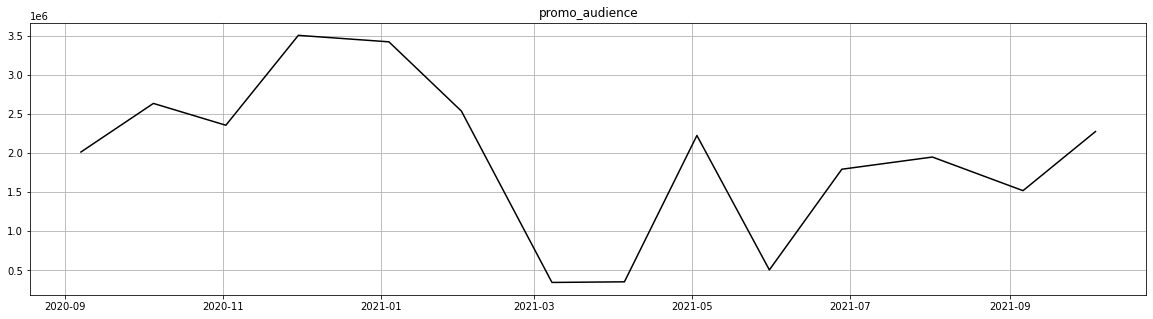

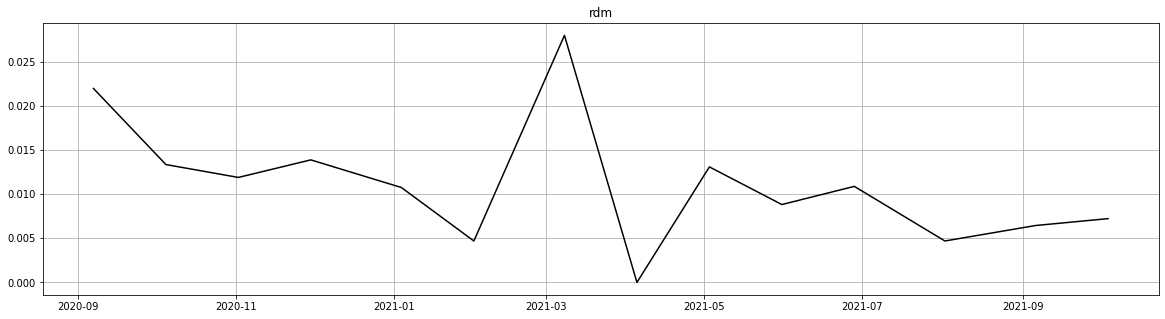

In [9]:
df = data.copy()[:-6]
df = df[df['offer_type']==OFFER_TYPE]
df = df[['fp_start_date', SCALE, METRIC]]
df.rename(columns={
    'fp_start_date': 'ds',
    METRIC: 'y',
    SCALE: 'scale'
}, inplace=True)

df = fortnight_impute(df)
df = prophet_impute(df)
df = negative_impute(df)

plt.figure(figsize=(20,5))
plt.plot(df.ds, df.scale, color='k')
plt.grid()
plt.title(SCALE)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(df.ds, df.y, color='k')
plt.grid()
plt.title(METRIC)
plt.show()

### Training

In [10]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

model = ETSModel(
    df.y[:-WINDOW],
    error="add",
    trend="add",
#     seasonal="add",
#     seasonal_periods=2,
    initialization_method="estimated"
)

model_fit = model.fit()
pred = model_fit.get_prediction(start=len(df.y)-WINDOW, end=len(df.y)-1)
pi = pred.summary_frame(alpha=0.05)

# Post process
if METRIC in ['rdm', 'cpc']:
    pi['mean'] = pi['mean'].apply(lambda x: 0 if x < 0 else x) 
    pi['pi_upper'] = pi['pi_upper'].apply(lambda x: 0 if x < 0 else x) 
    pi['pi_lower'] = pi['pi_lower'].apply(lambda x: 0 if x < 0 else x) 

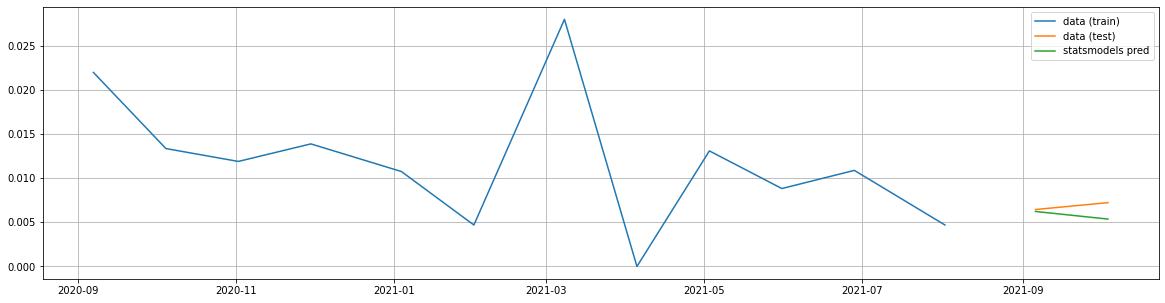

In [11]:
plt.figure(figsize=(20,5))
plt.plot(df.ds[:-WINDOW], df.y[:-WINDOW], label='data (train)')
plt.plot(df.ds[-WINDOW:], df.y[-WINDOW:], label='data (test)')
# plt.plot(df.ds[:-WINDOW], model_fit.fittedvalues, label='statsmodels fit')
plt.plot(df.ds[-WINDOW:], pi['mean'], label='statsmodels pred')
# plt.plot(df.ds[-WINDOW:], pi['pi_upper'], 'b--', alpha=0.25)
# plt.plot(df.ds[-WINDOW:], pi['pi_lower'], 'b--', alpha=0.25)
plt.legend()
plt.grid()
plt.show()

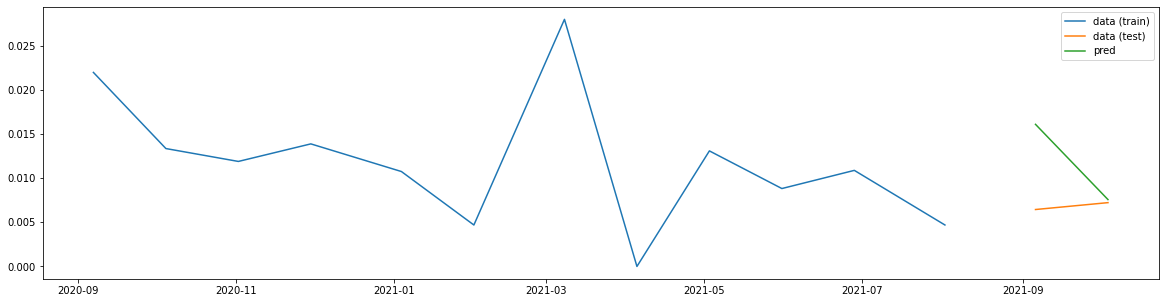

In [12]:
coeff = [ 1.0** i for i in range(6)]
def forecast_next(u, coeff):
    y = [coeff[i]**i*u[-2*(i+1)] for i in range(len(coeff))]
    return np.sum(y) / np.sum(coeff)

output = list(df.y[:-WINDOW])
for i in range(WINDOW):
    next_y = forecast_next(output, coeff)

    if (METRIC in ['rdm', 'cpc']) and (next_y < 0):
        output.append(0)
    else:
        output.append(next_y)

plt.figure(figsize=(20,5))
plt.plot(df.ds[:-WINDOW], df.y[:-WINDOW], label='data (train)')
plt.plot(df.ds[-WINDOW:], df.y[-WINDOW:], label='data (test)')
plt.plot(df.ds[-WINDOW:], output[-WINDOW:], label='pred')
plt.legend()
plt.show()

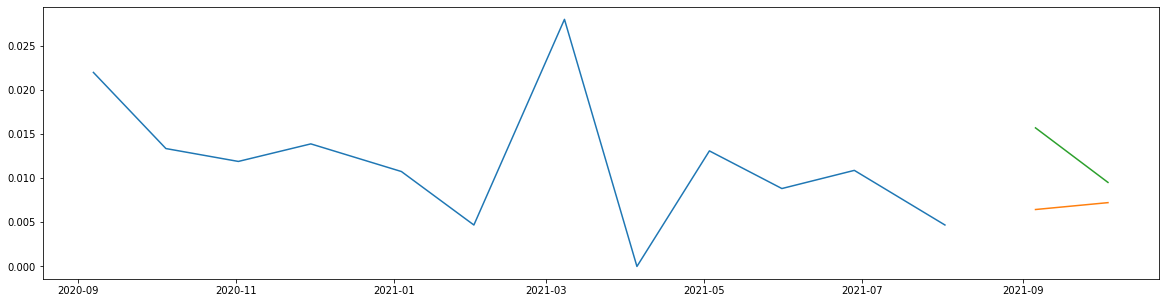

In [13]:
import pmdarima as pm

model = pm.auto_arima(
    df.y[:-WINDOW], 
    start_p=1,
    start_q=1,
    start_P=0)

plt.figure(figsize=(20,5))
plt.plot(df.ds[:-WINDOW], df.y[:-WINDOW], label='data (train)')
plt.plot(df.ds[-WINDOW:], df.y[-WINDOW:], label='data (test)')
plt.plot(df.ds[-WINDOW:], model.predict(WINDOW), label='meh')
plt.show()